# Plots for Siggi Paper

### Simple examples of information gain

In [1]:
# First import code
import sys
sys.path.append('..')

In [2]:
from siggi import siggi, filters, spectra, calcIG, plotting
from siggi import Sed
from siggi.lsst_utils import Bandpass, BandpassDict
import matplotlib.pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Set up red and blue spectra

In [106]:
f = filters()
s = spectra()
red_spec = s.get_red_spectrum()
blue_spec = s.get_blue_spectrum()

In [107]:
def flat_prior_2(z):
    return 0.5

In [108]:
sig_example = siggi([red_spec, blue_spec], [0.5, 0.5], flat_prior_2,
                    z_min=0.0, z_max=0.0, z_steps=1)

In [109]:
x = np.arange(400., 1001., 25.)
point_list = []
for val_1 in x:
    for val_2 in x:
        point_list.append([val_1, val_2])
y = np.arange(412.5, 1001., 25.)
for val_1 in y:
    point_list.append([val_1, val_1])

In [110]:
%%time
num_filters = 2
set_ratio = 0.5
res = sig_example.optimize_filters(num_filters=num_filters,
                                   filt_min=300., filt_max=1100.,
                                   sed_mags=22.0,
                                   set_ratio=set_ratio,
                                   system_wavelen_max=1200.,
                                   n_opt_points=15,
                                   optimizer_verbosity=5,
                                   procs=8, acq_func_kwargs_dict={'kappa':1.8},
                                   frozen_filt_dict = None,
                                   starting_points = [[mid-50., mid+50., mid_2-50., mid_2+50.] for mid, mid_2 in point_list])

[(300.0, 1100.0), (300.0, 1100.0), (300.0, 1100.0), (300.0, 1100.0)] [[300.0, 566.6666666666667, 833.3333333333334, 1100.0], [300.0, 433.33333333333337, 566.6666666666667, 700.0], [700.0, 833.3333333333334, 966.6666666666667, 1100.0], [396.74223334276667, 561.2272342184236, 619.1413415366889, 902.2291228653231], [543.1706603217426, 735.4646605224617, 791.4868958047232, 1094.1268945450674], [397.3113269056899, 402.69731365438304, 412.205652682855, 889.926807980644], [302.12751233542105, 644.9275452418142, 670.456611911922, 1087.5609396606253], [340.84631984948, 481.4290121894031, 921.4439997052123, 929.2144105335135], [468.1536043274639, 482.2434240562215, 702.424451667673, 919.1416576757467], [308.4356776743081, 756.7632478551079, 985.2518282904117, 1056.1021151928558]]


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    3.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    7.3s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:   13.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   20.8s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:   30.1s
[Parallel(n_jobs=8)]: Done 649 out of 649 | elapsed:   31.0s finished


-0.9953054557649327 649
CPU times: user 11min 10s, sys: 9min 33s, total: 20min 43s
Wall time: 1min 1s


### Make plots

In [111]:
min_idx = np.argmin(res.yi)

best_pt = res.Xi[min_idx]

In [112]:
best_val = np.min(res.yi)

In [113]:
print(best_pt, best_val)

[775.0, 875.0, 375.0, 475.0] -0.9953054557649327


In [118]:
# Uncomment if red and blue filters are on wrong sides
best_pt = [best_pt[2], best_pt[3], best_pt[0], best_pt[1]]

In [119]:
sig_plot = plotting([red_spec, blue_spec], best_pt,
                    frozen_filt_dict=None, set_ratio=0.5,
                    sed_mags=22.0)

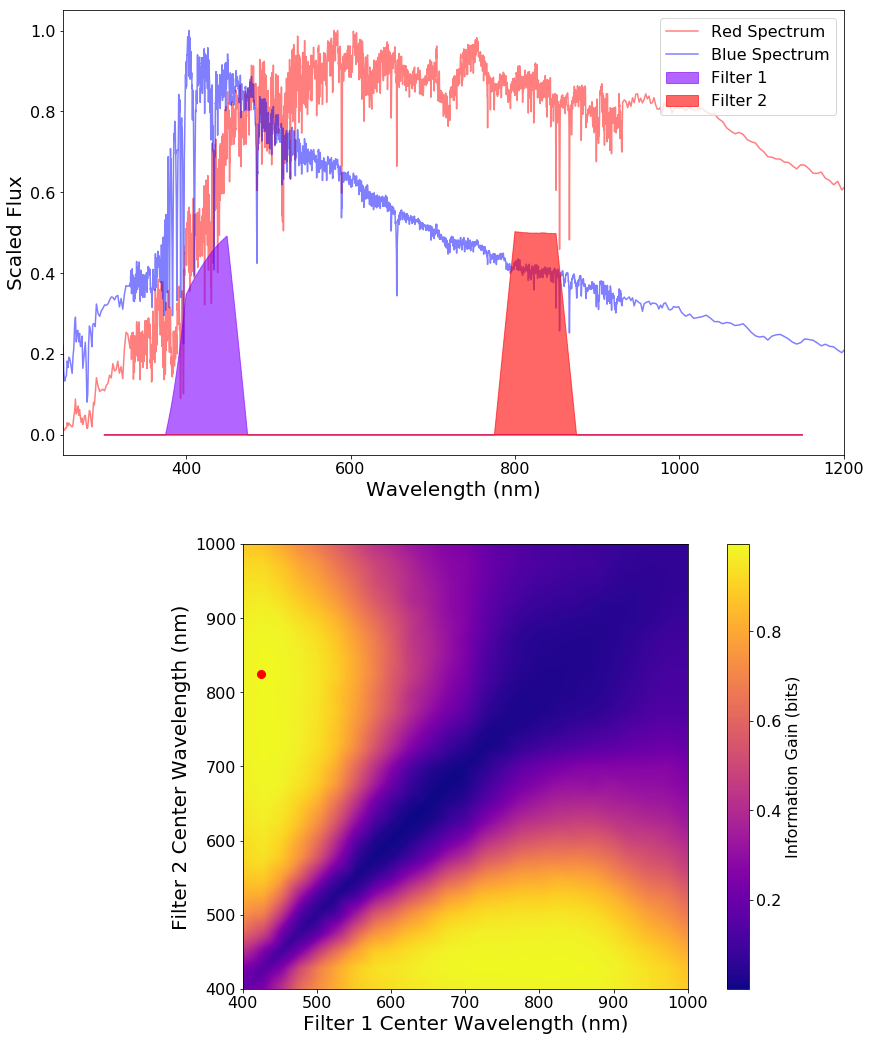

In [120]:
fig = plt.figure(figsize=(14, 18))
fig.add_subplot(2,1,1)
sig_plot.plot_filters(fig=fig)
ax = plt.gca()
ax.lines[0].set_color('r')
ax.lines[1].set_color('b')
plt.xlabel('Wavelength (nm)', size=20)
plt.ylabel('Scaled Flux', size=20)
plt.legend(('Red Spectrum', 'Blue Spectrum', 'Filter 1', 'Filter 2'), loc=1)
fig.add_subplot(2,1,2)
plt.rcParams.update({'font.size': 16})
sig_plot.plot_ig_space(res.Xi, np.abs(res.yi), [0,1])
cbar = plt.colorbar()
cbar.set_label('Information Gain (bits)')
plt.scatter(best_pt[0]+50., best_pt[2]+50., c='r', s=64)
plt.xlabel('Filter 1 Center Wavelength (nm)', size=20)
plt.ylabel('Filter 2 Center Wavelength (nm)', size=20)
plt.savefig('Example_1.pdf')

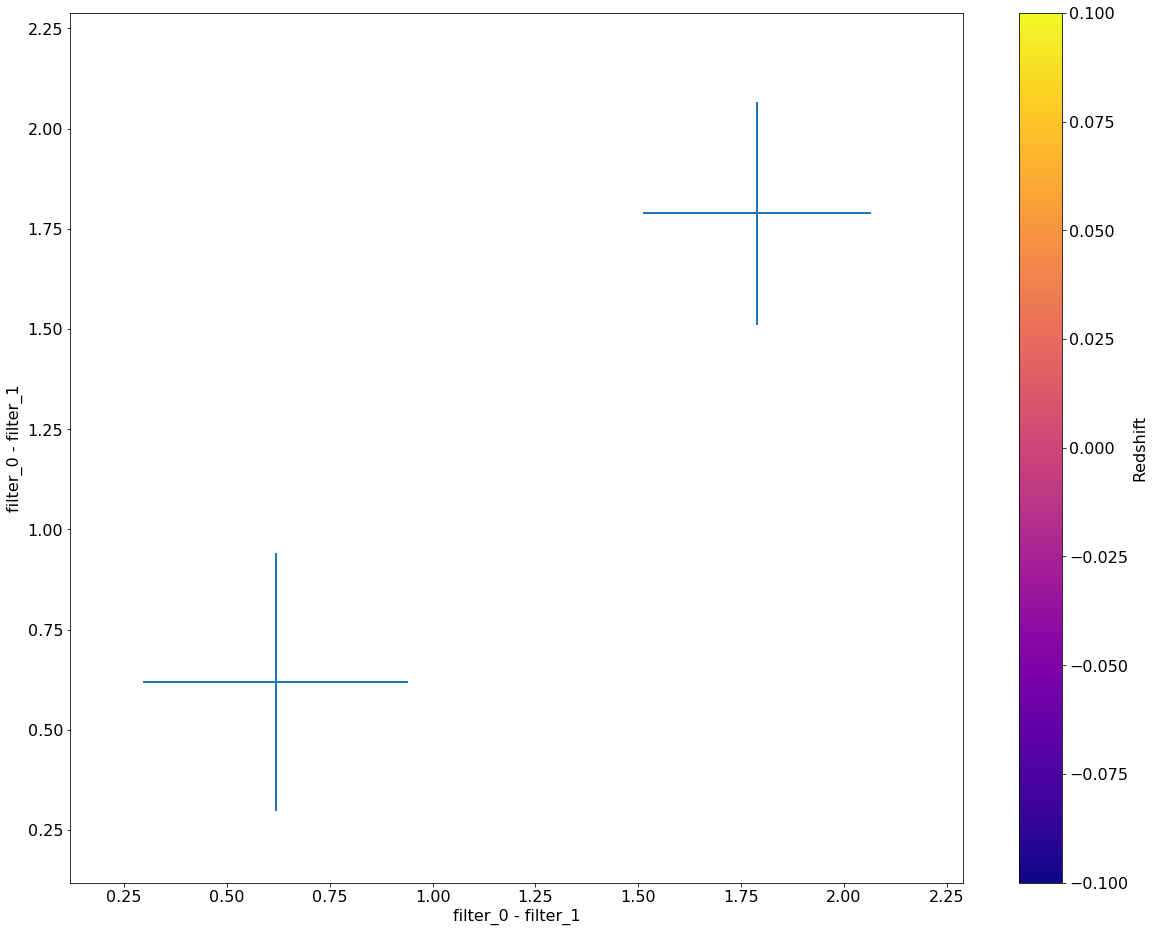

In [122]:
fig = plt.figure(figsize=(20,16))
fig = sig_plot.plot_color_color(['filter_0', 'filter_1', 'filter_0', 'filter_1'],
                                np.linspace(0.00, 0.0), fig=fig)

In [124]:
sig_plot.filter_dict.magListForSed(blue_spec), sig_plot.filter_dict.magListForSed(red_spec)

(array([-18.15774837, -18.80075315]), array([-17.73715795, -19.58054844]))

### Make sigmoid filter plot

In [15]:
sig_spec = s.get_sigmoid_spectrum()

In [16]:
sig_spec.wavelen[np.where(sig_spec.flambda < 0.01)] = 0.01

In [17]:
def prior_z(z, z0=0.5):
    return (z**2.)*np.exp(-(z/z0)**1.5)/(np.sum((np.arange(0, 2.51, .05)**2.)*np.exp(-(np.arange(0, 2.51, .05)/z0)**1.5)))

Text(0,0.5,'Prior Probability')

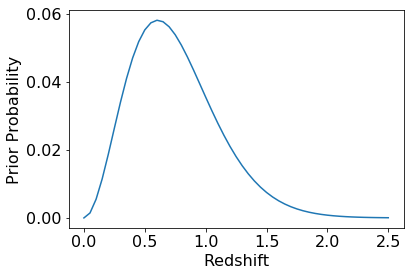

In [18]:
plt.plot(np.arange(0.00, 2.51, 0.05), prior_z(np.arange(0.00, 2.51, 0.05)))
plt.xlabel('Redshift')
plt.ylabel('Prior Probability')

(200, 500)

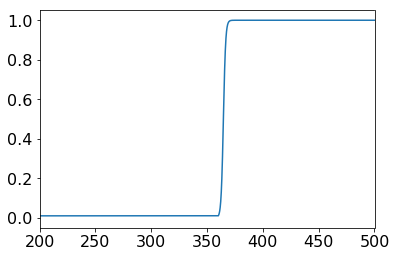

In [19]:
plt.plot(sig_spec.wavelen, sig_spec.flambda)
plt.xlim(200, 500)

In [20]:
x = np.arange(400., 1001., 25.)
point_list = []
for val_1 in x:
    for val_2 in x:
        point_list.append([val_1, val_2])
y = np.arange(412.5, 1001., 25.)
for val_1 in y:
    point_list.append([val_1, val_1])

In [21]:
ref_filter = Bandpass()
ref_filter.imsimBandpass()

In [22]:
sig_example = siggi([sig_spec], [1.0], prior_z,# calib_filter=ref_filter,
                    z_min=0.05, z_max=2.5, z_steps=50)

In [23]:
%%time
num_filters = 2
set_ratio = 0.5
res_2 = sig_example.optimize_filters(num_filters=num_filters,
                                     filt_min=300., filt_max=1100.,
                                     sed_mags=22.0,
                                     set_ratio=set_ratio,
                                     system_wavelen_max=1200.,
                                     n_opt_points=15,
                                     optimizer_verbosity=5,
                                     procs=16, acq_func_kwargs_dict={'kappa':1.8},
                                     frozen_filt_dict = None,
                                     starting_points = [[mid-50., mid+50., mid_2-50., mid_2+50.] for mid, mid_2 in point_list])

[(300.0, 1100.0), (300.0, 1100.0), (300.0, 1100.0), (300.0, 1100.0)] [[300.0, 566.6666666666667, 833.3333333333334, 1100.0], [300.0, 433.33333333333337, 566.6666666666667, 700.0], [700.0, 833.3333333333334, 966.6666666666667, 1100.0], [861.7278984313663, 884.378054293356, 904.3691053355567, 991.1431771840228], [583.144337254286, 675.9023304323456, 744.9214084422429, 1014.1223217648362], [629.2360995580209, 641.5673869249222, 727.9494629095849, 775.4193443152385], [508.2323163142439, 886.1162901839103, 994.6799805910956, 1082.743566202228], [527.485814119925, 642.279834535695, 718.869615122592, 942.3814395947109], [427.01216415766964, 652.0207679222051, 834.1714184475411, 896.9234397644944], [624.1543226288643, 682.9985582530865, 721.2807725244697, 727.5305098297467]]


[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:   34.3s
[Parallel(n_jobs=16)]: Done 130 tasks      | elapsed:  1.8min
[Parallel(n_jobs=16)]: Done 256 tasks      | elapsed:  3.4min
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:  5.6min
[Parallel(n_jobs=16)]: Done 616 tasks      | elapsed:  8.2min
[Parallel(n_jobs=16)]: Done 649 out of 649 | elapsed:  8.6min finished


-2.159208753592012 649
CPU times: user 14min 27s, sys: 14min 14s, total: 28min 42s
Wall time: 9min 15s


In [24]:
min_idx = np.argmin(res_2.yi)
best_pt = res_2.Xi[min_idx]
print(best_pt)

[725.0, 825.0, 550.0, 650.0]


In [25]:
# Uncomment if redder filter is first
best_pt = [best_pt[2], best_pt[3], best_pt[0], best_pt[1]]

In [26]:
sig_spec.redshiftSED(0.6)
sig_plot = plotting([sig_spec], best_pt,
                    frozen_filt_dict=None, set_ratio=0.5,
                    sed_mags=22.0)

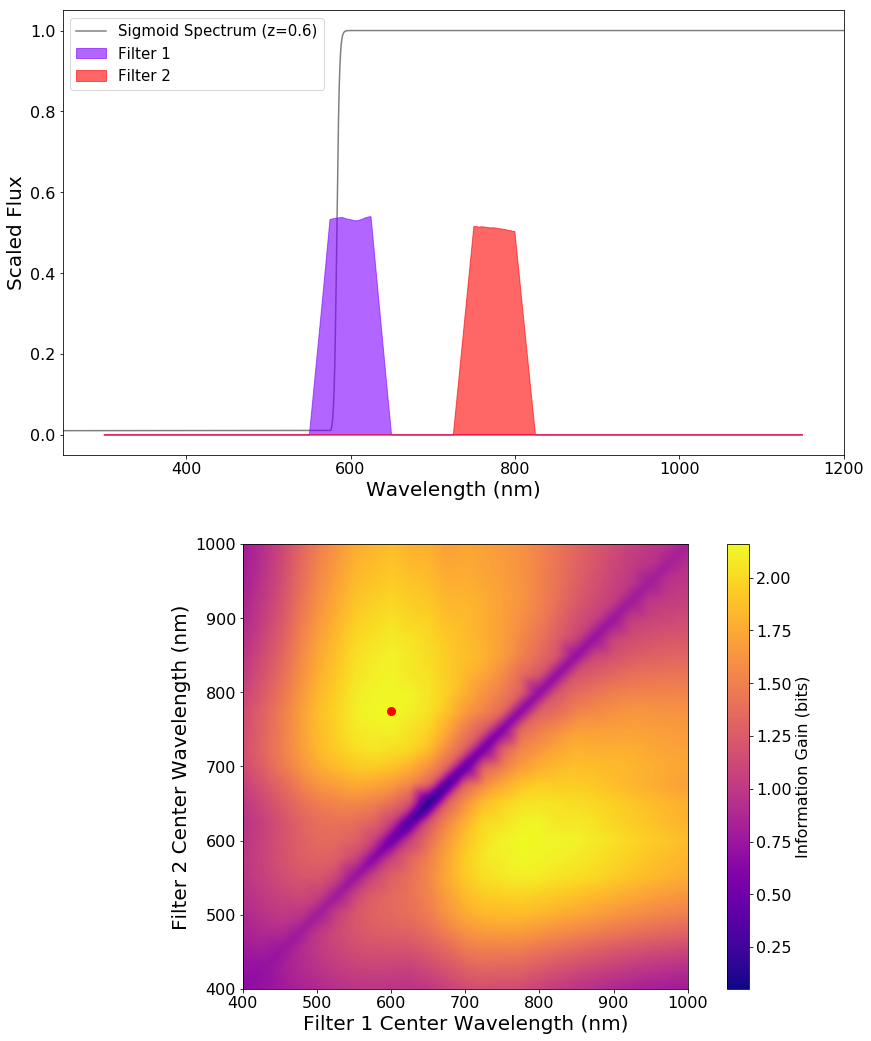

In [27]:
fig = plt.figure(figsize=(14, 18))
fig.add_subplot(2,1,1)
sig_plot.plot_filters(fig=fig)
ax = plt.gca()
plt.xlabel('Wavelength (nm)', size=20)
plt.ylabel('Scaled Flux', size=20)
plt.legend(('Sigmoid Spectrum (z=0.6)', 'Filter 1', 'Filter 2'), loc=2, fontsize=15)
fig.add_subplot(2,1,2)
plt.rcParams.update({'font.size': 16})
sig_plot.plot_ig_space(res_2.Xi, np.abs(res_2.yi), [0,1])
cbar = plt.colorbar()
cbar.set_label('Information Gain (bits)')
plt.scatter(best_pt[0]+50., best_pt[2]+50., c='r', s=64)
plt.xlabel('Filter 1 Center Wavelength (nm)', size=20)
plt.ylabel('Filter 2 Center Wavelength (nm)', size=20)
plt.savefig('Example_2.pdf')

In [28]:
from copy import deepcopy
shift_seds = []

sig_spec = s.get_sigmoid_spectrum()
sig_spec.flambda[np.where(sig_spec.flambda < 0.01)] = 0.01

#best_pt = [350., 450., 400., 500.]
#best_pt = [800., 900., 900., 1000.]
#best_pt = [600.0, 700.0, 825.0, 925.0]

sig_plot = plotting([sig_spec], best_pt,
                    frozen_filt_dict=None, set_ratio=0.5,
                    sed_mags=22.0)

for sed_obj in [sig_spec]:
    for z_val in np.linspace(0.05, 2.5, 50):
        sed_copy = deepcopy(sed_obj)
        sed_copy.redshiftSED(z_val)
        shift_seds.append(sed_copy)

calc_ig = calcIG(sig_plot.filter_dict, shift_seds,
                         np.ones(len(shift_seds)),
                         sky_mag=19.0, sed_mags=22.0)
col_x, err_x = calc_ig.calc_colors()


Text(0,0.5,'Color ($F_2$ - $F_{1}$)')

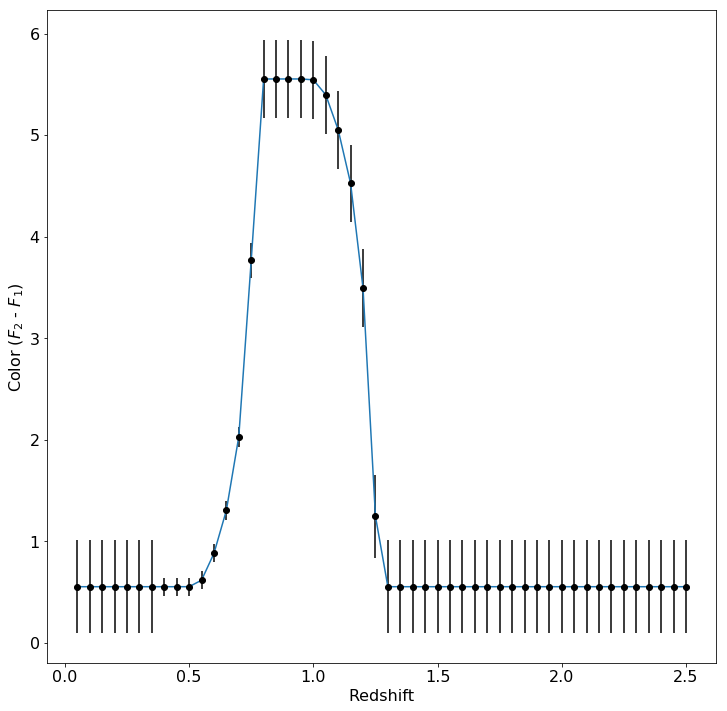

In [29]:
fig = plt.figure(figsize=(12,12))
plt.plot(np.linspace(0.05, 2.5, 50), col_x)
plt.errorbar(np.linspace(0.05, 2.5, 50), col_x, yerr=err_x**.5, ls='', marker='o', color='k')
plt.xlabel('Redshift')
plt.ylabel(r'Color ($F_2$ - $F_{1}$)')

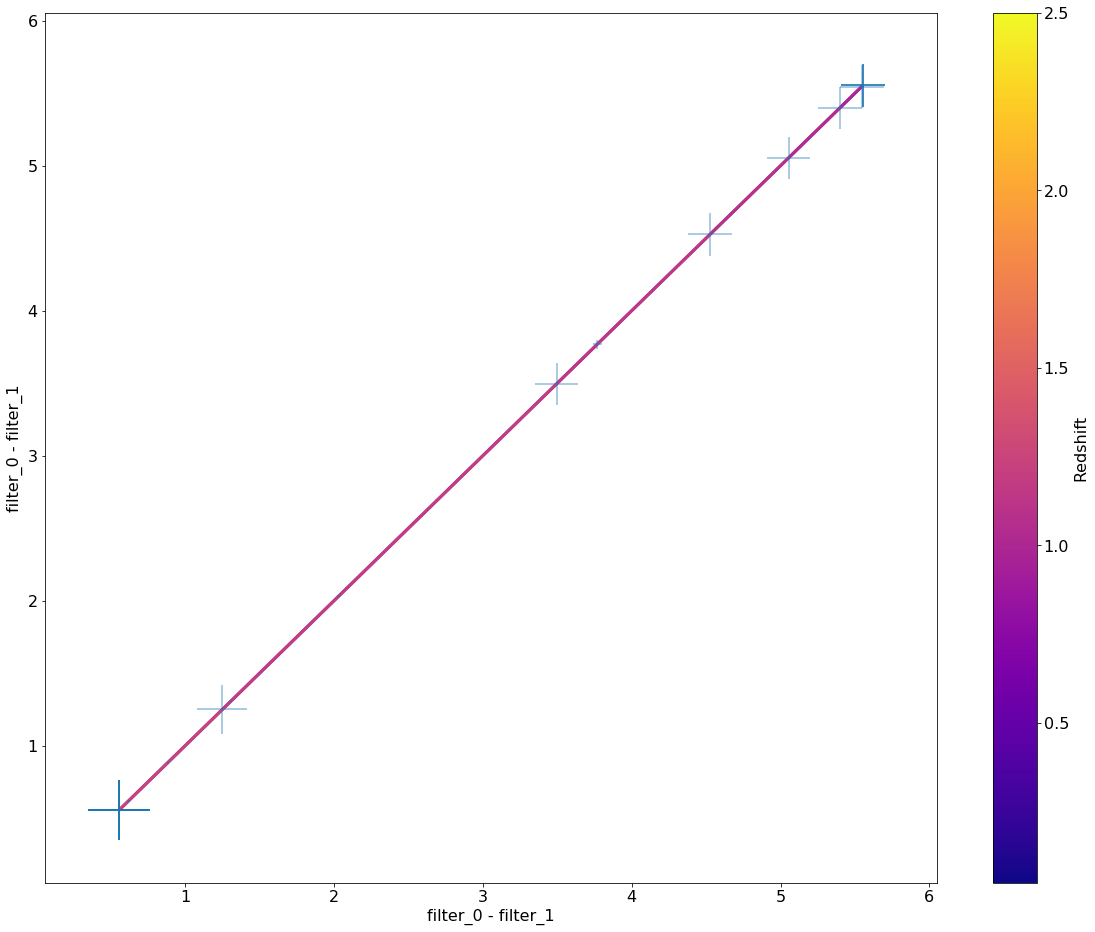

In [30]:
fig = plt.figure(figsize=(20,16))
fig = sig_plot.plot_color_color(['filter_0', 'filter_1', 'filter_0', 'filter_1'],
                                np.linspace(0.05, 2.5, 50), fig=fig)

In [56]:
blue_spec = s.get_blue_spectrum()

In [57]:
x = np.arange(400., 1001., 25.)
point_list = []
for val_1 in x:
    for val_2 in x:
        point_list.append([val_1, val_2])
y = np.arange(412.5, 1001., 25.)
for val_1 in y:
    point_list.append([val_1, val_1])

In [58]:
sig_example = siggi([blue_spec], [1.0], prior_z,
                    z_min=0.05, z_max=2.5, z_steps=50)

In [59]:
%%time
num_filters = 2
set_ratio = 0.5
res_3 = sig_example.optimize_filters(num_filters=num_filters,
                                     filt_min=300., filt_max=1100.,
                                     sed_mags=22.0,
                                     set_ratio=set_ratio,
                                     system_wavelen_max=1200.,
                                     n_opt_points=15,
                                     optimizer_verbosity=5,
                                     procs=16, acq_func_kwargs_dict={'kappa':1.8},
                                     frozen_filt_dict = None,
                                     starting_points = [[mid-50., mid+50., mid_2-50., mid_2+50.] for mid, mid_2 in point_list])

[(300.0, 1100.0), (300.0, 1100.0), (300.0, 1100.0), (300.0, 1100.0)] [[300.0, 566.6666666666667, 833.3333333333334, 1100.0], [300.0, 433.33333333333337, 566.6666666666667, 700.0], [700.0, 833.3333333333334, 966.6666666666667, 1100.0], [335.82387064172616, 405.32557965844563, 443.59881310520905, 998.3081783999469], [352.3719443530974, 367.92534874218325, 514.4449049514756, 698.8813328600429], [468.78659788855487, 758.4109602567007, 780.7490396327848, 1025.5422010416387], [308.8272526278636, 975.6930584742615, 989.6116587677933, 1086.778688319605], [401.7080990955474, 570.4215133019497, 996.1630118503793, 1005.2758655477893], [317.8149705778056, 564.2570333143761, 780.4467211204143, 803.4333594333358], [501.4662217607578, 754.128167368496, 818.3200906524586, 937.4707801505906]]


[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:   39.8s
[Parallel(n_jobs=16)]: Done 130 tasks      | elapsed:  1.8min
[Parallel(n_jobs=16)]: Done 256 tasks      | elapsed:  3.5min
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:  5.7min
[Parallel(n_jobs=16)]: Done 616 tasks      | elapsed:  8.4min
[Parallel(n_jobs=16)]: Done 649 out of 649 | elapsed:  8.7min finished


-1.8871850281875315 649
CPU times: user 10min 23s, sys: 8min 51s, total: 19min 15s
Wall time: 9min 11s


In [63]:
min_idx = np.argmin(res_3.yi)
best_pt = res_3.Xi[min_idx]
print(best_pt)

[525.0, 625.0, 825.0, 925.0]


In [ ]:
# Uncomment if blue and red filters are reversed
# best_pt = [best_pt[2], best_pt[3], best_pt[0], best_pt[1]]

In [64]:
blue_spec.redshiftSED(0.6)
sig_plot = plotting([blue_spec], best_pt,
                    frozen_filt_dict=None, set_ratio=0.5,
                    sed_mags=22.0)

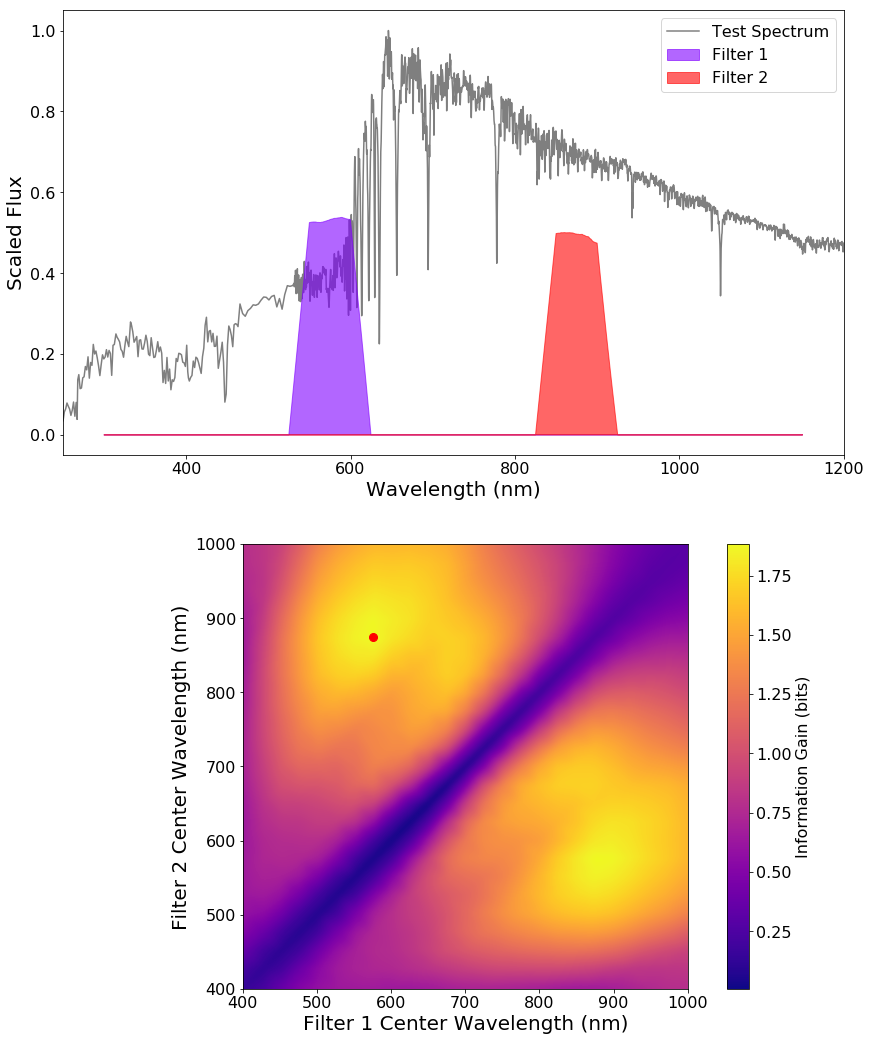

In [65]:
fig = plt.figure(figsize=(14, 18))
fig.add_subplot(2,1,1)
sig_plot.plot_filters(fig=fig)
ax = plt.gca()
plt.xlabel('Wavelength (nm)', size=20)
plt.ylabel('Scaled Flux', size=20)
plt.legend(('Test Spectrum', 'Filter 1', 'Filter 2'), loc=1)
fig.add_subplot(2,1,2)
plt.rcParams.update({'font.size': 16})
sig_plot.plot_ig_space(res_3.Xi, np.abs(res_3.yi), [0,1])
cbar = plt.colorbar()
cbar.set_label('Information Gain (bits)')
plt.scatter(best_pt[0]+50., best_pt[2]+50., c='r', s=64)
plt.xlabel('Filter 1 Center Wavelength (nm)', size=20)
plt.ylabel('Filter 2 Center Wavelength (nm)', size=20)
plt.savefig('Example_3.pdf')

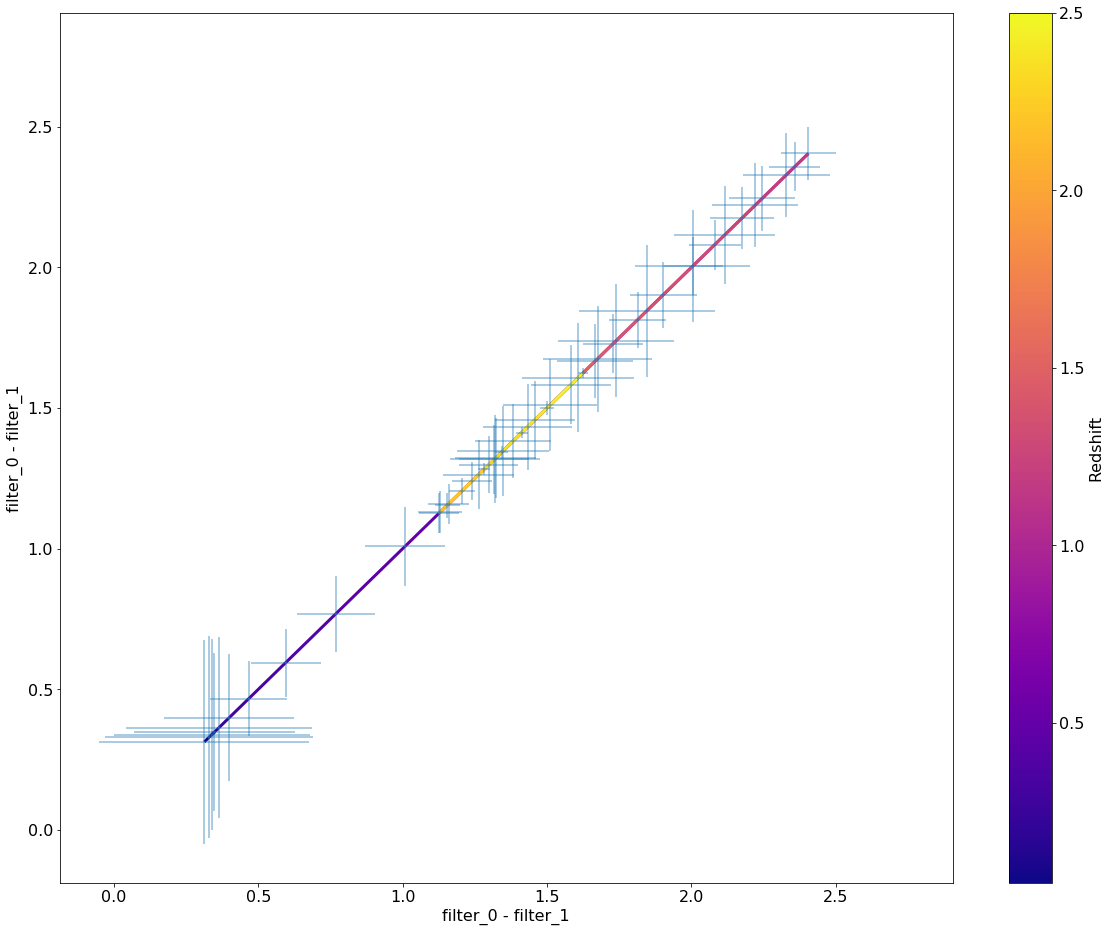

In [37]:
fig = plt.figure(figsize=(20,16))
fig = sig_plot.plot_color_color(['filter_0', 'filter_1', 'filter_0', 'filter_1'],
                                np.linspace(0.05, 2.5, 50), fig=fig)